In [1]:
import pandas as pd
import numpy as np
import warnings
from ProcessPriceData import ProcessPriceData
from Backtester import Backtester
from StatisticalArbitrage import StatisticalArbitrage
from statsmodels.api import OLS
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

warnings.filterwarnings("ignore")

In [50]:
# Reading the data

df = pd.read_excel('HDFC ICICI 2010 D.xlsx')
df.set_index(df['Date'], inplace=True)
df.drop(['Date'], axis=1, inplace=True)
df.dropna(inplace=True)
df  

,HDFCBANK,ICICIBANK
Date,,
2010-01-04 15:30:00,170.57,159.95
2010-01-05 15:30:00,170.72,161.46
2010-01-06 15:30:00,170.84,162.70
2010-01-07 15:30:00,171.28,161.16
2010-01-08 15:30:00,171.51,158.90
...,...,...
2024-03-07 15:30:00,1446.10,1087.95
2024-03-11 15:30:00,1427.80,1078.70
2024-03-12 15:30:00,1459.55,1076.85


In [51]:
df = ProcessPriceData(df)
dfn = df.normalize_prices()
dfn

,HDFCBANK,ICICIBANK
Date,,
2010-01-04 15:30:00,1.000000,1.000000
2010-01-05 15:30:00,1.000879,1.009440
2010-01-06 15:30:00,1.001583,1.017193
2010-01-07 15:30:00,1.004163,1.007565
2010-01-08 15:30:00,1.005511,0.993435
...,...,...
2024-03-07 15:30:00,8.478044,6.801813
2024-03-11 15:30:00,8.370757,6.743982
2024-03-12 15:30:00,8.556897,6.732416


In [52]:
# Initializing Parameters

inst1_n = dfn['HDFCBANK']
inst2_n = dfn['ICICIBANK']
model = 0
datetime = []
equity = []
look_back = 10
timeperiod = 10
nbdevup, nbdevdn=2,2
long_target, short_target = 1,1
position = 0
signal = ''
capital = 10000000
sprd = pd.DataFrame(columns = ['Spread', 'Margin'])
qty = []
trade_type = []
entry= []
exit = []
entry_price= []
exit_price = []

In [53]:
# Running the backtest

for i in range(0, len(dfn)):
    
    if i== 0:
        equity.append(capital)
        datetime.append(dfn.index[i])
        model = OLS([1,1], [1,1])
        model = model.fit()
        
    statarb = StatisticalArbitrage(inst1_n, inst2_n)
        
    val, model = statarb.calculate_hedge_ratio(i, look_back, model)         
    margin = statarb.spread_margin(hedge_ratio = model.params[0])
    
    sprd.loc[len(sprd)] = [val, margin]
    
    if len(sprd) < timeperiod:
        continue
        
    bb = statarb.bollinger_bands_on_spread(sprd, timeperiod, nbdevup, nbdevdn, long_target, short_target)
    
    # Generating Signals
        
    signal = statarb.bollinger_signals(bb)
        
    # Executing Trades
    
    backtest = Backtester(dfn, prices=sprd['Spread'], margins=sprd['Margin'])
        
    position, qty, equity, datetime, trade_type, entry, exit, entry_price, exit_price = backtest.execute_trades(datetime=datetime,
                                                                                                                i=i,
                                                                                                                capital=capital,
                                                                                                                signal=signal,
                                                                                                                position=position,
                                                                                                                qty=qty,
                                                                                                                equity=equity,
                                                                                                                trade_type=trade_type,
                                                                                                                entry=entry,
                                                                                                                exit=exit,
                                                                                                                entry_price=entry_price,
                                                                                                                exit_price=exit_price)

In [54]:
trade_log = backtest.create_trade_log(qty, trade_type, entry, exit, entry_price, exit_price)
trade_log

,Entry Date,Entry Price,Quantity,Exit Date,Exit Price,Trade Type
0,2010-02-01 15:30:00,-0.048336,642441.0,2010-02-15 15:30:00,-0.018386,Long
1,2010-02-17 15:30:00,0.008831,652687.0,2010-03-02 15:30:00,-0.003294,Short
2,2010-03-23 15:30:00,0.042816,652387.0,2010-04-05 15:30:00,-0.010736,Short
3,2010-05-19 15:30:00,0.070226,631073.0,2010-05-31 15:30:00,-0.011804,Short
4,2010-07-14 15:30:00,0.037979,614533.0,2010-07-16 15:30:00,-0.004525,Short
...,...,...,...,...,...,...
158,2023-09-08 15:30:00,0.174504,1898559.0,2023-09-21 15:30:00,-0.127880,Short
159,2023-10-04 15:30:00,0.012192,1928598.0,2023-11-02 15:30:00,-0.066436,Short
160,2023-12-04 15:30:00,0.060846,1955678.0,2023-12-20 15:30:00,0.049409,Long
161,2023-12-21 15:30:00,0.245134,1938447.0,2024-01-10 15:30:00,-0.211141,Short


In [55]:
accuracy, long_accuracy, short_accuracy = backtest.calculate_accuracy(trade_log)
accuracy, long_accuracy, short_accuracy 

(0.8834355828220859, 0.8888888888888888, 0.8780487804878049)

,Strategy
CAGR,0.101462
MAX DD,-0.063000
Sharpe Ratio,0.856414
Sortino Ratio,0.188496
Calmar Ratio,1.600000


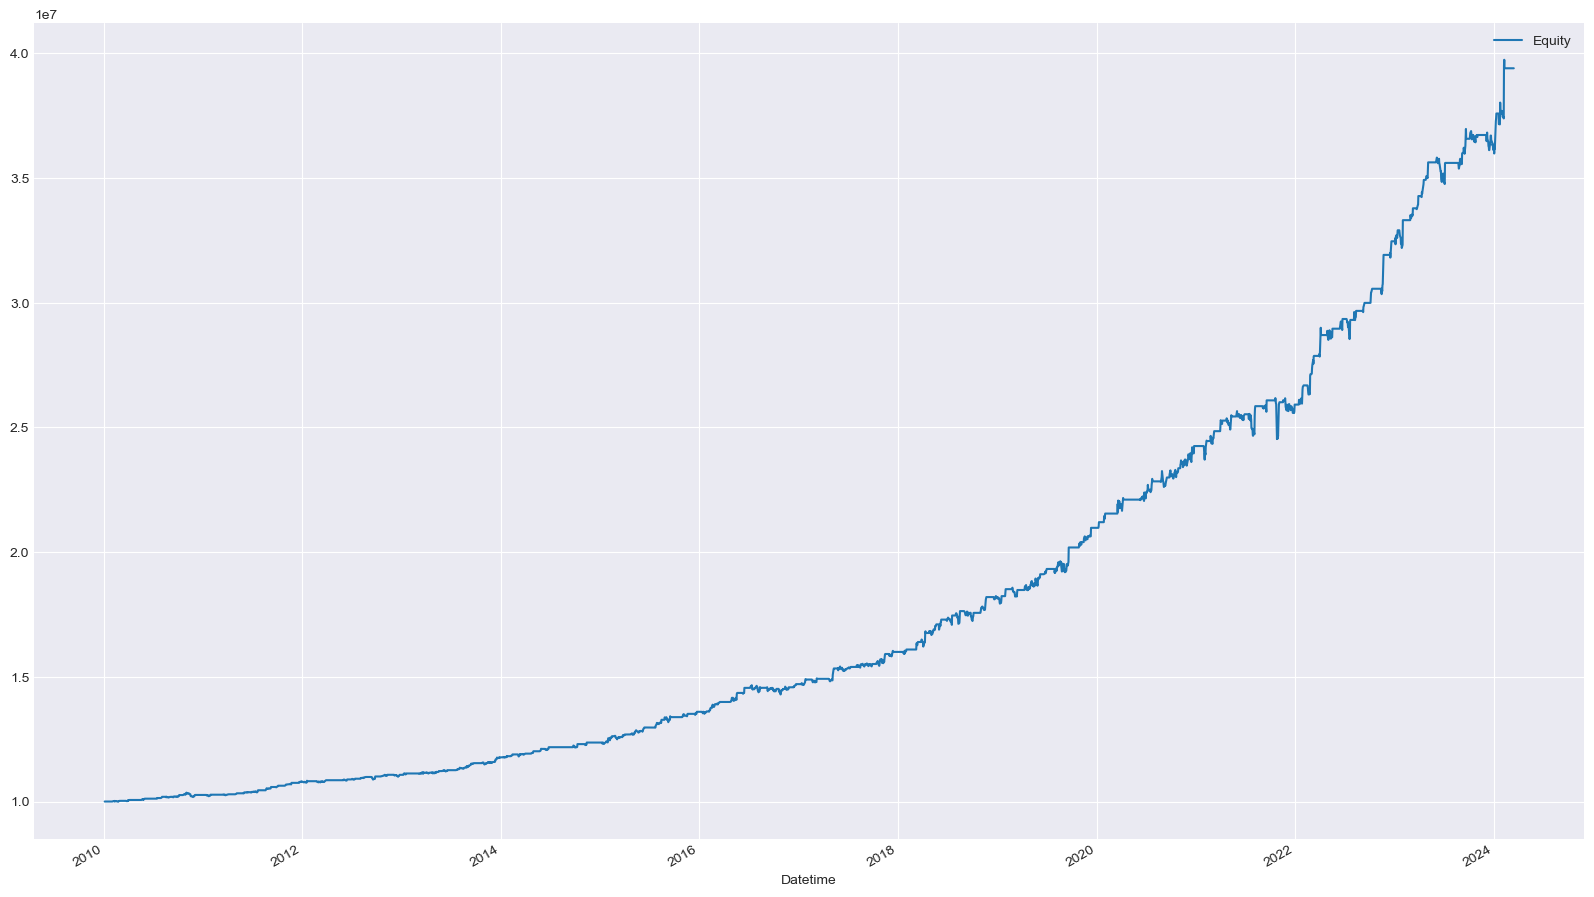

In [56]:
account, results = backtest.calculate_backtest_results(datetime, equity)
results